In [58]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.pyplot.gray()

%matplotlib inline

import numpy as np
import theano
import theano.tensor as T
from theano import shared, function
theano.config.floatX = 'float32'
rng = np.random.RandomState(42)

import sys
import time

import theano.tensor as T
from theano import function
from theano import shared
import theano
import numpy
from theano.sandbox.rng_mrg import MRG_RandomStreams
from theano.tensor.shared_randomstreams import RandomStreams
import os
import time
from pandas import DataFrame, Series
import pandas as pd
from theano.tensor.signal import downsample
from theano.tensor.nnet import conv
import numpy as np
import h5py

# ComputeFest 2015 - Deep Learning Workshop Part 2 - Convolutional Networks

Today we will focus on deep convolutional neural networks. We'll use the handwritten digit recognition task, again.  We'll build up a network with a pair of convolutional layers with two fully connected layers above that.

The first part of this tutorial is similar (though not identical, we skip normalization) to yesterday's notebook on fully-connected networks.

We will make heavy use of the resources in the Theano deep learning tutorial. Please clone the repository so you have all the resources at hand. 

`git clone git://github.com/lisa-lab/DeepLearningTutorials.git`

Now we have to add this directory to the PythonPath. Depending on the location of your git repository you might have to change this path.

In [59]:
sys.path.insert(1,'DeepLearningTutorials/code')
sys.path

['',
 'DeepLearningTutorials/code',
 'DeepLearningTutorials/code',
 'DeepLearningTutorials/code',
 'DeepLearningTutorials/code',
 '/Users/colediamond/Dropbox/Documents/Harvard/Spring/CS205/Project/pylearn2',
 '/usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/django_allauth-0.11.0_dev-py2.7.egg',
 '/usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/gensim-0.8.7-py2.7.egg',
 '/usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/Topics-0.2.5-py2.7-macosx-10.8-x86_64.egg',
 '/usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/EssessCV-0.1-py2.7.egg',
 '/usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pycuda-2014.1-py2.7-macosx-10.10-x86_64.egg',
 '/usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/py

## The Task: Handwritten Digit Recognition 
Classifying handwritten digits is like the 'hello world' for deep learning methods. It is how everyone normally starts to get used to the models and how to best train them. Interstingly though, it is not just for beginners. There are still papers published nowadays that use MNIST to evaluate new methods. There is some debate on whether this is still useful or not, but we won't care about this discussion for now. 

MNIST consists of 70 000 small image patches, each showing a handwritten digit character in white on a black background. There are 10 different classes (the digits from 0-9). Let's load the data and have a look.

In [60]:
def load_data(hdf5_file):
    ''' Loads the dataset
    '''

    #############
    # LOAD DATA #
    #############

    print '... loading data'

    # Load the dataset
    hdf5 = h5py.File(hdf5_file,'r')
    train_set_x = hdf5['X_train'][:]
    test_set_x = hdf5['X_test'][:]
    valid_set_x = hdf5['X_valid'][:]
    train_set_y = hdf5['y_train'][:]
    test_set_y = hdf5['y_test'][:]
    valid_set_y = hdf5['y_valid'][:]

    #train_set, valid_set format: tuple(input, target)
    #input is an numpy.ndarray of 2 dimensions (a matrix)
    #witch row's correspond to an example. target is a
    #numpy.ndarray of 1 dimensions (vector)) that have the same length as
    #the number of rows in the input. It should give the target
    #target to the example with the same index in the input.

    def shared_dataset(data_x, data_y, borrow=True):
        """ Function that loads the dataset into shared variables

        The reason we store our dataset in shared variables is to allow
        Theano to copy it into the GPU memory (when code is run on GPU).
        Since copying data into the GPU is slow, copying a minibatch everytime
        is needed (the default behaviour if the data is not in a shared
        variable) would lead to a large decrease in performance.
        """
        shared_x = theano.shared(numpy.asarray(data_x, dtype=theano.config.floatX), borrow=borrow)
        shared_y = theano.shared(numpy.asarray(data_y, dtype=theano.config.floatX), borrow=borrow)
        # When storing data on the GPU it has to be stored as floats
        # therefore we will store the labels as ``floatX`` as well
        # (``shared_y`` does exactly that). But during our computations
        # we need them as ints (we use labels as index, and if they are
        # floats it doesn't make sense) therefore instead of returning
        # ``shared_y`` we will have to cast it to int. This little hack
        # lets ous get around this issue
        return shared_x, T.cast(shared_y, 'int32')

    valid_set_x, valid_set_y = shared_dataset(valid_set_x, valid_set_y)
    train_set_x, train_set_y = shared_dataset(train_set_x, train_set_y)
    test_set_x, test_set_y = shared_dataset(test_set_x, test_set_y)

    rval = [(train_set_x, train_set_y), (valid_set_x, valid_set_y),
            (test_set_x, test_set_y)]
    return rval

In [61]:
datasets = load_data("Data/hdf5/sample.hdf5")

... loading data


In [62]:
train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]

## Theano Shared Variables

In [63]:
print train_set_x

<TensorType(float32, matrix)>


Now that looks a bit odd, why can't we see the values of our data matrix? The `load_data` function provided by the deep learning tutorial downloads the data and loads it into a shared variable. Shared variables are an important and genious concept in Theano. What it means is that the data can be shared between the CPU and the GPU without you having to write a single line of code! You basically do not have to care at all where your data lives, unless you are running out of memory, which is another story we can talk about later. For now let us only worry about how we can access the actual values of the data matrix:

In [64]:
print train_set_x.get_value()

[[ 0.02706758  0.02706758  0.02706758 ...,  0.02700506  0.02700506
   0.02700506]
 [ 0.04544618  0.04544618  0.04544618 ...,  0.04538485  0.04538485
   0.04538485]
 [ 0.04485763  0.04485763  0.04485763 ...,  0.04485763  0.04485763
   0.04485763]
 ..., 
 [ 0.04946565  0.04946565  0.04946565 ...,  0.04946565  0.04946565
   0.04946565]
 [ 0.03664047  0.03664047  0.03664047 ...,  0.03670236  0.03670236
   0.03670236]
 [ 0.04871043  0.04871043  0.04871043 ...,  0.04871043  0.04871043
   0.04871043]]


In [65]:
print "Size of the training data matrix: ", train_set_x.get_value().shape

Size of the training data matrix:  (30, 1572864)


The data is stored with one training sample per row. The original image patches are $28 \times 28$ pixels, hence we have $28 \cdot 28 = 784$ feature columns in our data matrix. We can reshape each row of our data matrix back to the original $28 \times 28$ image patch to visualize what the data looks like.

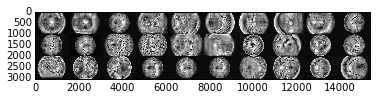

In [66]:
from utils import tile_raster_images
ishape = (1024, 1536)
samples = tile_raster_images(train_set_x.get_value(), img_shape=(ishape[0],ishape[1]), tile_shape=(3,10), tile_spacing=(0, 0),
                       scale_rows_to_unit_interval=True,
                       output_pixel_vals=True)

plt.imshow(samples)
plt.show()

So each image patch contains a hand written digit in white on a black background. The strokes vary in thickness and there is quite some variability in the hand writing. 

The labels of the different image patches are stored in our variable `train_set_y`. When we print this variable it looks different than for our training data, and there is no `get_value()` function that we can call to access the labels.

In [67]:
print train_set_y

Elemwise{Cast{int32}}.0


The reason is that the `load_data` function casted our labels to integers. Why would it do that? The GPU can only store float variables, so all shared variables are stored as float. Our labels are integers though and later on we want to use them as indices, which requires them to be integers. As a workaround `load_data` first stores the labels as floats and then casts them to integer. As you can see from the `print` statement, Theano does not execute the casting right away. Instead it keeps a record of all the computations that are to be performed on the shared variable in a computational graph. This is another genious concept of Theano, because when these graphs get more complicated, it optimizes the whole graph for computational efficiency and numerical stability. If you want to know more about the computational graph structures and their optimization in Theano you can look [here](http://deeplearning.net/software/theano/tutorial/symbolic_graphs.html).

To access the labels we need to tell Theano to exectue all computations from the corresponding graph. We do this by calling `eval()`:

In [68]:
print train_set_y.eval()[:10]

[4 4 4 4 4 4 4 4 4 4]


<hr>

# Convolutional Network

We'll create a convolutional network to classify digits.  We use code from the Deep Network Tutorials to make this a little easier, particularly the Convolutional Layer class **`LeNetConvPoolLayer`**, [defined in convolutional_mlp.py](https://github.com/lisa-lab/DeepLearningTutorials/blob/master/code/convolutional_mlp.py#L39).

We'll build up a network using the following layers:
* input (1 channel)
* 10  1x9x9 filters   &mdash; (first dimension is 1 because the input image is grayscale)
* 10  10x5x5 filters  &mdash; (first dimenions is 10 because the previous layer had 10 filters)
* a fully connected sigmoidal layer with 20 outputs
* a fully connected Logistic Regression layer with 10 outputs

We'll train with batches, with a batch size of 500.

## Setup for the Convolutional Network

In [69]:
# Setup 1: parameters of the network and training
from convolutional_mlp import LeNetConvPoolLayer
from mlp import HiddenLayer
from logistic_sgd import LogisticRegression

# network parameters
num_kernels = [10, 10]
kernel_sizes = [(9, 9), (5, 5)]
sigmoidal_output_size = 20

# training parameters
learning_rate = 0.1
batch_size = 50

For efficiency, we break the data into batches.  Our network will take **`batch_size`** images at a time as input.

In [70]:
# Setup 2: compute batch sizes for train/test/validation

# borrow=True gets us the value of the variable without making a copy.
n_train_batches = train_set_x.get_value(borrow=True).shape[0]
n_test_batches = test_set_x.get_value(borrow=True).shape[0]
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
n_train_batches /= batch_size
n_test_batches /= batch_size
n_valid_batches /= batch_size

In [71]:
# Setup 3.

# Declare inputs to network - x and y are placeholders
# that will be used in the training/testing/validation functions below.
x = T.matrix('x')  # input image data
y = T.ivector('y') # input label data

## Layer 0 - First convolutional Layer

The first layer takes **`(batch_size, 1, 28, 28)`** as input, convolves it with **10** different **9x9** filters, and then downsamples (via maxpooling) in a **2x2** region.  Each filter/maxpool combination produces an output of size **`(28-9+1)/2 = 10`** on a side.

The size of the first layer's output is therefore **`(batch_size, 10, 10, 10)`**. 

In [72]:

layer0_input_size = (batch_size, 1, 28, 28)  # fixed size from the data
edge0 = (28 - kernel_sizes[0][0] + 1) / 2
layer0_output_size = (batch_size, num_kernels[0], edge0, edge0)
# check that we have an even multiple of 2 before pooling
assert ((28 - kernel_sizes[0][0] + 1) % 2) == 0

# The actual input is the placeholder x reshaped to the input size of the network
layer0_input = x.reshape(layer0_input_size)

layer0 = LeNetConvPoolLayer(rng,
                            input=layer0_input,
                            image_shape=layer0_input_size,
                            filter_shape=(num_kernels[0], 1) + kernel_sizes[0],
                            poolsize=(2, 2))

## Layer 1 - Second convolutional Layer

The second layer takes **`(batch_size, 10, 10, 10)`** as input, convolves it with 10 different **10x5x5** filters, and then downsamples (via maxpooling) in a **2x2** region.  Each filter/maxpool combination produces an output of size **`(10-5+1)/2 = 3`** on a side.

The size of the second layer's output is therefore **`(batch_size, 10, 3, 3)`**. 

In [73]:
layer1_input_size = layer0_output_size
edge1 = (edge0 - kernel_sizes[1][0] + 1) / 2
layer1_output_size = (batch_size, num_kernels[1], edge1, edge1)
# check that we have an even multiple of 2 before pooling
assert ((edge0 - kernel_sizes[1][0] + 1) % 2) == 0

layer1 = LeNetConvPoolLayer(rng,
                            input=layer0.output,
                            image_shape=layer1_input_size,
                            filter_shape=(num_kernels[1], num_kernels[0]) + kernel_sizes[1],
                            poolsize=(2, 2))

## Layer 2 - Fully connected sigmoidal layer

The sigmoidal layer takes a vector as input.

We flatten all but the first two dimensions, to get an input of size **`(batch_size, 30 * 4 * 4)`**.

In [74]:
layer2_input = layer1.output.flatten(2)

layer2 = HiddenLayer(rng,
                     input=layer2_input,
                     n_in=num_kernels[1] * edge1 * edge1,
                     n_out=sigmoidal_output_size,
                     activation=T.tanh)

## Layer 3 - Logistic regression output layer

A fully connected logistic regression layer converts the sigmoid's layer output to a class label.

In [75]:
layer3 = LogisticRegression(input=layer2.output,
                            n_in=sigmoidal_output_size,
                            n_out=10)

## &lt;/Convolutional Network>

<hr>

# Training the network

To train the network, we have to define a cost function.  We'll use the Negative Log Likelihood of the model, relative to the true labels **`y`**.

In [76]:
# The cost we minimize during training is the NLL of the model.
# Recall: y is a placeholder we defined above
cost = layer3.negative_log_likelihood(y)

### Gradient descent

We will train with Stochastic Gradient Descent.  To do so, we need the gradient of the cost relative to the parameters of the model.  We can get the parameters for each label via the **`.params`** attribute.

In [77]:
# create a list of all model parameters to be fit by gradient descent
params = layer3.params + layer2.params + layer1.params + layer0.params

# create a list of gradients for all model parameters
grads = T.grad(cost, params)

## Training function

The actual training function takes a batch of inputs (images **`x`** and labels **`y`**), and updates the model parameters with a small step in the steepest direction that reduces the gradient.

This is the
**`(param_i, param_i - learning_rate * grad_i)`**
line in the code below.

We use the **`updates`** keyword to **`theano.function()`** to update these variables in-place.  See [the documentation for function()](http://deeplearning.net/software/theano/library/compile/function.html).

We also make use of the **`givens`** keyword, to alias **`x`** and **`y`** to batches (aka, slices) of  **`train_set_x`** and **`train_set_y`**.

In [78]:
# train_model is a function that updates the model parameters by SGD, and returns the current cost
#
# We create the updates list by automatically looping over all
# (params[i], grads[i]) pairs.
updates = [
    (param_i, param_i - learning_rate * grad_i)  # <=== SGD update step
    for param_i, grad_i in zip(params, grads)
]

index = T.lscalar()  # index to a batch of training/validation/testing examples

train_model = theano.function(
    [index],
    cost,
    updates=updates,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size],  # <=== batching
        y: train_set_y[index * batch_size: (index + 1) * batch_size]   # <=== batching
    }
)

## Validation function

To track progress on a held-out set, we count the number of misclassified examples in the validation set.

In [79]:
validate_model = theano.function(
        [index],
        layer3.errors(y),
        givens={
            x: valid_set_x[index * batch_size: (index + 1) * batch_size],
            y: valid_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

## Test function

After training, we check the number of misclassified examples in the test set.

In [80]:
test_model = theano.function(
    [index],
    layer3.errors(y),
    givens={
        x: test_set_x[index * batch_size: (index + 1) * batch_size],
        y: test_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

<hr>

# Training loop

We use SGD for a fixed number of iterations over the full training set (an "epoch").  Usually, we'd use a more complicated rule, such as iterating until a certain number of epochs fail to produce improvement in the validation set.  

In [81]:
for epoch in range(10):
    costs = [train_model(i) for i in xrange(n_train_batches)]
    validation_losses = [validate_model(i) for i in xrange(n_valid_batches)]
    print "Epoch {}    NLL {:.2}    %err in validation set {:.1%}".format(epoch + 1, np.mean(costs), np.mean(validation_losses))

Epoch 1    NLL nan    %err in validation set nan%
Epoch 2    NLL nan    %err in validation set nan%
Epoch 3    NLL nan    %err in validation set nan%
Epoch 4    NLL nan    %err in validation set nan%
Epoch 5    NLL nan    %err in validation set nan%
Epoch 6    NLL nan    %err in validation set nan%
Epoch 7    NLL nan    %err in validation set nan%
Epoch 8    NLL nan    %err in validation set nan%
Epoch 9    NLL nan    %err in validation set nan%
Epoch 10    NLL nan    %err in validation set nan%


## Learned features

We can visualize the filters learned by the first layer.  In most vision tasks, these will be simple features, such as lines, points, or edges (such as in Figure 2 of [this paper](http://www.cs.toronto.edu/~rgrosse/icml09-cdbn.pdf)).

The MNIST data doesn't contain as much variation as natural images, so we don't see as obvious edge features, but we still see some stroke-like features appearing in the lowest level.  With some standard tricks (adding noise to the training set, shifting examples around, using Dropout), we'd probably see smoother features (as in the paper linked above).

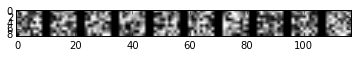

In [82]:
filters = tile_raster_images(layer0.W.get_value(borrow=True), img_shape=(9, 9), tile_shape=(1,10), tile_spacing=(3, 3),
                       scale_rows_to_unit_interval=True,
                       output_pixel_vals=True)

plt.imshow(filters)
plt.show()

## Check performance on the test set

In [83]:
test_errors = [test_model(i) for i in range(n_test_batches)]
print "test errors: {:.1%}".format(np.mean(test_errors))

test errors: nan%
